# The preprocess pipeline

## The goal of the preprocess pipeline

The preprocess pipeline ensures that:

1.	**There are no duplicate values in the dataset’s timestamps**. Duplicate timestamps are treated separately for each feature. In all cases, if the range of the feature’s values that share a timestamp is short – according to a user-defined threshold– they are replaced by their average. Otherwise, they are treated as missing values.


2.	**There are no missing values in the dataset’s timestamps**. If there are missing timestamps, they are added and the respective data is treated as missing values.


3. If the data that is available for the training of the baseline predictive model covers more than one full year, **potential data drift is identified**. The existence of data drift means that there is a change in the distribution of data over time. The user can choose to disable data drift detection.


4. **Potential outliers are identified and marked**. Outlier detection is carried out separately for each feature. The user can choose the features for which the outlier detection step will run.


5. **There are no missing values in the outdoor air temperature data**. If temperature data is missing, the missing values are imputed. The outdoor air temperature changes smoothly from one hour to the next, so interpolating over a 6-hour window around a missing observation is a sensible approach for imputation.


6. **There is enough data available for the energy consumption of the building under study**. Baseline energy consumption data must cover at least one full year before any energy efficiency intervention. In addition, data must be available for over a user-defined percentage of hours in each calendar month – after excluding the potential outliers.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import datetime, timedelta

pd.plotting.register_matplotlib_converters()

In [2]:
from eensight.utils import recover_missing_dates
from eensight.utils.jupyter import load_catalog
from eensight.pipelines.preprocess import (
    validate_input_data,
    detect_drift,
    decompose_consumption,
    decompose_temperature,
    global_filter, 
    global_outlier_detect, 
    local_outlier_detect,
    linear_impute
)

### Load the data catalog for the demo building

In [3]:
catalog = load_catalog('demo', partial_catalog=True)

### Case A: If more than one full years of consumption data is available

To demonstrate the data drift detection approach, we will merge the `train` and the `apply` data: 

In [4]:
%%time

train_input = catalog.load('train.root_input')
data_train = validate_input_data(train_input, rebind_names=catalog.load('rebind_names'))

apply_input = catalog.load('apply.root_input')
data_apply = validate_input_data(apply_input, rebind_names=catalog.load('rebind_names'))

data_all = pd.concat((data_train, data_apply))

2021-11-14 16:57:30,487 - kedro.io.data_catalog - INFO - Loading data from `train.root_input` (PartitionedDataSet)...
2021-11-14 16:57:30,493 - kedro.io.data_catalog - INFO - Loading data from `rebind_names` (MemoryDataSet)...
2021-11-14 16:57:41,337 - kedro.io.data_catalog - INFO - Loading data from `apply.root_input` (PartitionedDataSet)...
2021-11-14 16:57:41,339 - kedro.io.data_catalog - INFO - Loading data from `rebind_names` (MemoryDataSet)...
Wall time: 18.8 s


In [5]:
data_all = pd.concat((data_train, data_apply))

In [6]:
print('The data covers the period from '
      f'{data_all.index.min()} to {data_all.index.max()}'
)

The data covers the period from 2015-11-18 00:00:00 to 2017-11-10 23:45:00


In [7]:
consumption =  data_all['consumption']

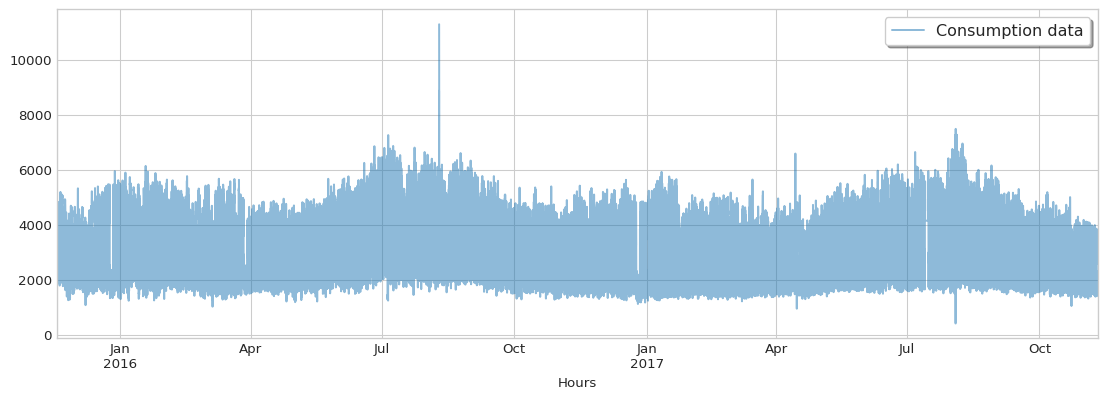

In [8]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 4.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    consumption.plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Hours')
    ax.legend(['Consumption data'], frameon=True, shadow=True, fontsize=12)

Although it is not easy to spot from the plot, there is a difference between the data for 2016 and the data for 2017:

In [9]:
consumption_ext = consumption.to_frame('consumption')
consumption_ext['date'] = consumption_ext.index.date
consumption_ext['time'] = consumption_ext.index.time

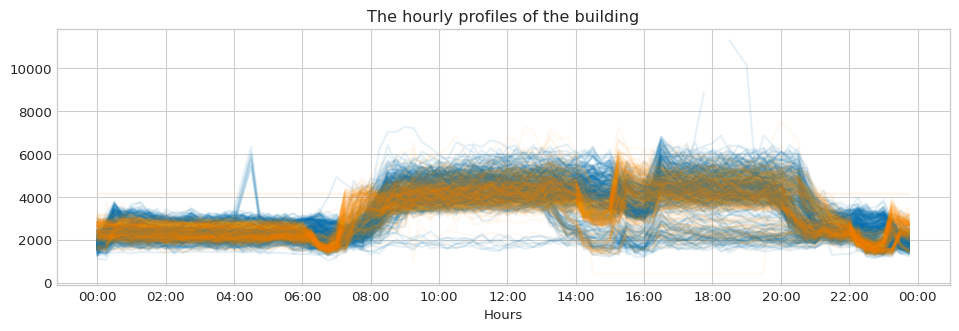

In [10]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption_ext[consumption_ext.index.year <= 2016].pivot(
            index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.1, legend=None, color='#0570b0')
    
    consumption_ext[consumption_ext.index.year > 2016].pivot(
            index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.05, legend=None, color='#FF8C00')
    
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

### Detect data drift

When the data that is available for the training of the predictive model covers more than one full year, it is good practice to test for data drift. The detection of data drift is done using a paired learners approach. In particular:

* Suppose that the data covers three (3) years: 2018, 2019, 2020. 


* First, a predictive model is trained on the 2019-2020 period. We use a gradient-boosting tree model with no additional encoding of the available features. 


* Next, a predictive model is trained on the 2019 period, and the two distributions that arise from the residuals of each model over the common period (2019) are compared using a two-sample Kolmogorov-Smirnov test. 


* The test is applied over a rolling window that simultaneously traverses both the residual time series. If, and for as long as, the test suggests a difference in the distributions, the first observation of the rolling window is assigned a “drift” tag:

 <img src="images/paired_step_1.png?modified=12345678" alt="grouped" width="500"/>


* This process is repeated by expanding the data that is used for fitting the first model, while excluding the observations that were tagged as “drift”: 

 <img src="images/paired_step_2.png?modified=12345678" alt="grouped" width="500"/>
 

The end result of this process is the input dataset with an additional, Boolean feature “drift” that indicates where drift was detected. All subsequent operations on the dataset exclude the observations where “drift” is true.

In [11]:
%%time
data_all = detect_drift(data_all)

2021-11-14 16:59:16,315 - drift-detection - INFO - Applying paired learners, long period: [2017, 2016], short period: 2016
2021-11-14 17:01:50,296 - drift-detection - INFO - Applying paired learners, long period: [2017, 2016, 2015], short period: 2015
Wall time: 3min


The next plot shows where drift was detected in the data:

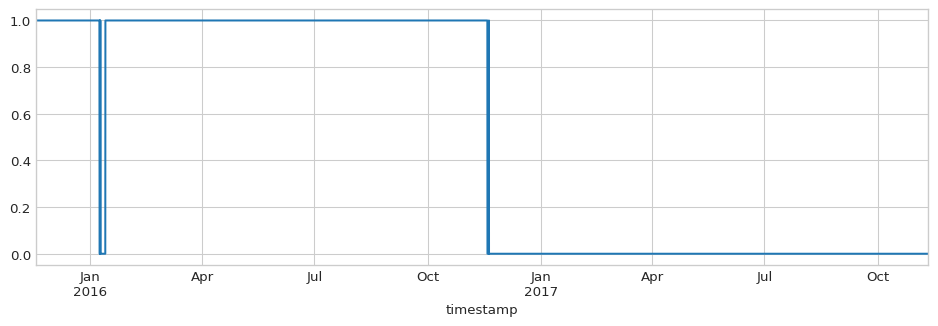

In [12]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    data_all['drift'].astype(int).plot(ax=ax)

Remove drift data from the dataset and recover missing timestamps:

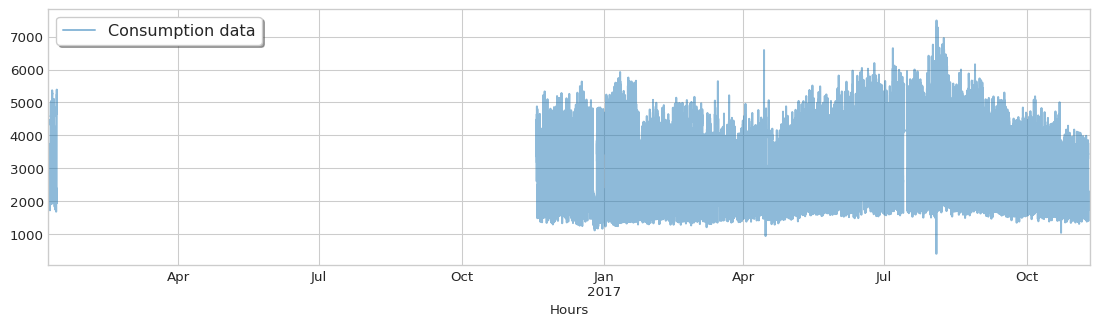

In [13]:
data_all = data_all[~data_all['drift']].drop('drift', axis=1)
data_all = recover_missing_dates(data_all)

consumption =  data_all['consumption']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    consumption.plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Hours')
    ax.legend(['Consumption data'], frameon=True, shadow=True, fontsize=12)

Let's see how the data from 2016 that was included in the dataset looks like compared to the data for 2017:

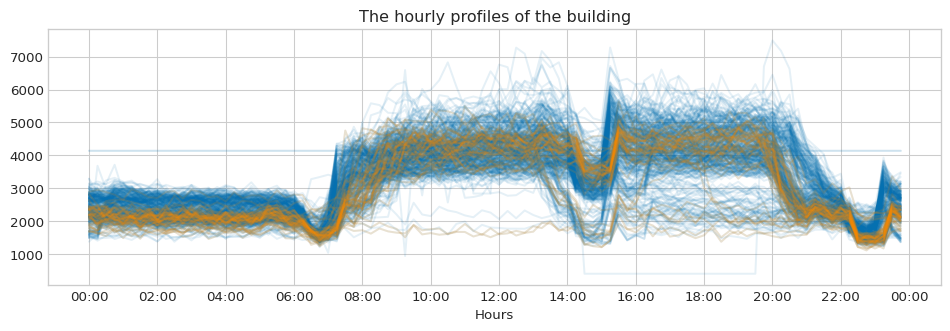

In [14]:
consumption = data_all['consumption']

consumption_ext = consumption.to_frame('consumption')
consumption_ext['date'] = consumption_ext.index.date
consumption_ext['time'] = consumption_ext.index.time

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption_ext.pivot(
            index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.1, legend=None, color='#0570b0')
    
    consumption_ext[consumption_ext.index.year <= 2016].pivot(
            index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.15, legend=None, color='#FF8C00')
    
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

### Case B: Only one full year of consumption data is available

Use only the training data:

In [15]:
consumption =  data_train['consumption']

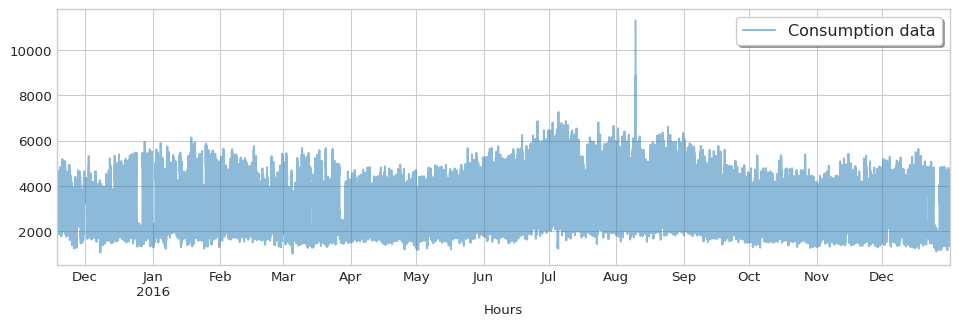

In [16]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    consumption.plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Hours')
    ax.legend(['Consumption data', 'Consumption data with detected drift'], 
              frameon=True, shadow=True, fontsize=12)

### Outlier identification

The proposed approach for outlier identification is outlined next:

#### Step 1: Global filter

The first step screens for non-physically plausible values in the data. Furthermore, long streaks of constant values are filtered out as well (here *long* is defined in hours by `no_change_window`). However, long streaks of constant values will not be filtered out if they represent more than the `max_pct_of_dummy` percentange of the dataset.

In [17]:
consumption = global_filter(consumption, 
                            no_change_window=3,
                            max_pct_of_dummy=0.1,
                            allow_zero=False, 
                            allow_negative=False
)

#### Step 2: Seasonal filter

The second step captures the seasonal cycle of the data through a trend and seasonality decomposition approach that utilizes a Fourier series expansion of the form:

$$y(t)=\alpha+bt+\sum_{n=1}^{N} (\alpha_n\cos(\frac{2πnt}{P}) + b_n\sin(\frac{2πnt}{P}))$$

where:

$\alpha$    is the offset of the linear trend

$b$    is the slope of the linear trend

$t$    is the day since a pre-specified epoch. For hourly data, $t$ will take decimal number values.

$N$    is a parameter that controls the flexibility of the expansion. Suggested values are N=4 for daily seasonality, N=10 for yearly seasonality (see [Taylor S. J. and Letham B. (2018) "Forecasting at scale," The American Statistician 72(1), pp. 37-45](https://peerj.com/preprints/3190/))

$P$    is the length of the seasonality: P=1 for daily seasonality, P=365.25 for yearly seasonality. For energy consumption data, we fit a different daily seasonality component for each day of the week.  

$\alpha_n, b_n$	Regression coefficients for the Fourier series expansion terms.


The reason for applying seasonal decomposition before outlier identification can be seen in the figure below: 

In [18]:
def fit_pdf(x, data, distribution=stats.norm):
    # fit dist to data
    params = distribution.fit(data)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Calculate fitted PDF and error with fit in distribution
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
    return params, pdf

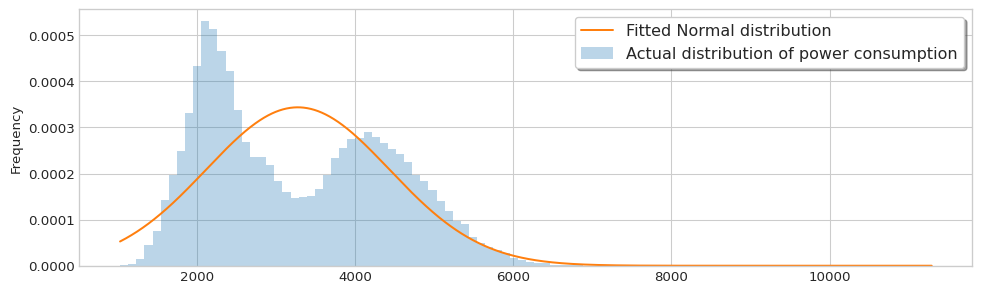

In [19]:
consumption_ = consumption.dropna().values
x_d = np.linspace(consumption_.min(), consumption_.max(), 2000)
params, pdf = fit_pdf(x_d, consumption_)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption.plot(kind='hist', bins=100, density=True, alpha=0.3, ax=ax)
    pd.Series(pdf, x_d).plot(ax=ax)
    
    ax.legend(['Fitted Normal distribution', 'Actual distribution of power consumption'], 
              frameon=True, shadow=True, fontsize=12)

Since seasonality leads to multimodal distributions, methods that rely on the assumption that the data follows a Normal distribution – such as simple three-sigma rules, the Grubbs test or the Extreme Studentized Deviate (ESD) test  – should generally be used only ***after*** a seasonal filter has been applied to the data.

In [20]:
%%time

results = decompose_consumption(
        consumption.dropna().to_frame("consumption"),
        return_model=False
)

Wall time: 12.6 s


In [21]:
pred = results.prediction["consumption"]
resid = consumption - pred
resid = resid.dropna()

The coefficient of variation of the RMSE of the seasonal model is:

In [22]:
print(
    f'CV(RMSE): {np.sqrt(np.mean(resid**2))/np.mean(consumption)}'
)

CV(RMSE): 0.17729524323586188


The next plot shows the actual and the predicted power consumption for the first and the last month of 2016:

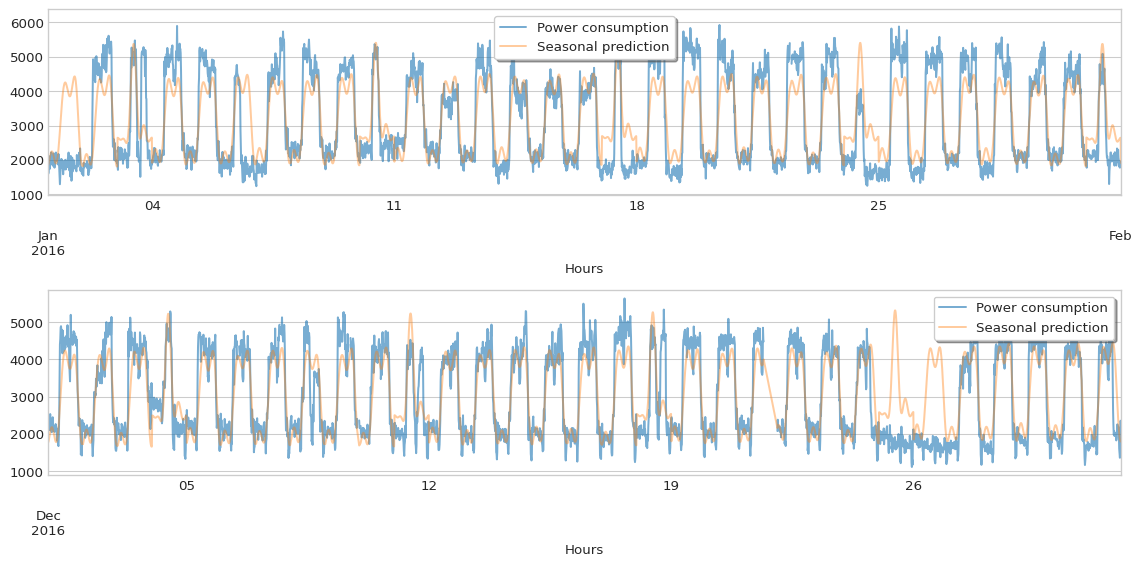

In [23]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 6), dpi=96)
    layout = (2, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))

    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    consumption.loc[start:end].plot(ax=ax1, alpha=0.6)
    pred.loc[start:end].plot(ax=ax1, alpha=0.4)
    ax1.set_xlabel('Hours')
    ax1.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    consumption.loc[start:end].plot(ax=ax2, alpha=0.6)
    pred.loc[start:end].plot(ax=ax2, alpha=0.4)
    ax2.set_xlabel('Hours')
    ax2.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)

fig.tight_layout()

The next plot shows the distribution of the residuals when subtracting the actual from the predicted power consumption. The distribution of the residuals resembles a Student’s t distribution and, hence, it is easier to work with for detecting outliers.

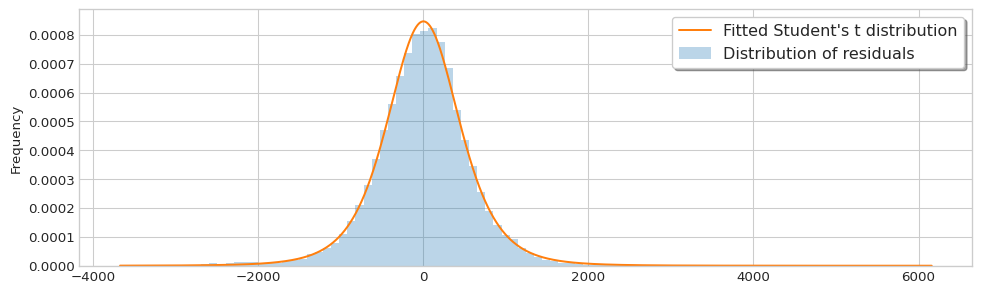

In [24]:
x_d = np.linspace(resid.min(), resid.max(), 2000)
_, pdf_t = fit_pdf(x_d, resid, distribution=stats.t)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    resid.plot(kind='hist', bins=100, density=True, alpha=0.3, ax=ax)
    pd.Series(pdf_t, x_d).plot(ax=ax)
    
    ax.legend(['Fitted Student\'s t distribution', 'Distribution of residuals'], 
              frameon=True, shadow=True, fontsize=12)

#### Step 3: Global outlier detection

The third step of the outlier detection process identifies observations in the available dataset as potential outliers if the value of their corresponding residuals lies outside the range defined by:

$$[median^{all} - c\times mad^{all}, median^{all} + c\times mad^{all}]$$

where:

$median^{all}$ is the median of all the residual values

$mad^{all}$ is the median absolute deviation of all the residual values

$c$ is a user defined parameter (suggested value is 7).


In [25]:
outliers_global = global_outlier_detect(resid, c=7)

The result `outliers_global` is a pandas Series of outlier scores. Zero values mean no outlier, non zero values mean probable outlier, and the higher the score, the higher the probability:

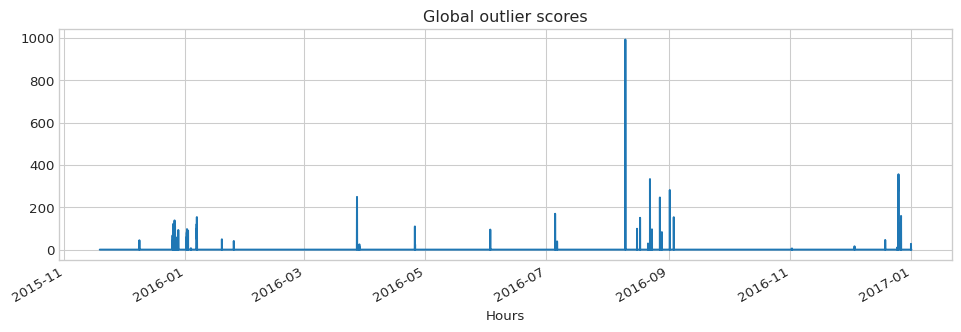

In [26]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    outliers_global.plot(ax=ax)
    ax.set_xlabel('Hours')
    ax.set_title('Global outlier scores')

The next plot shows the potential outliers in power consumption identified using the global outlier detection for January, August, first 5 days of September and December 2016:

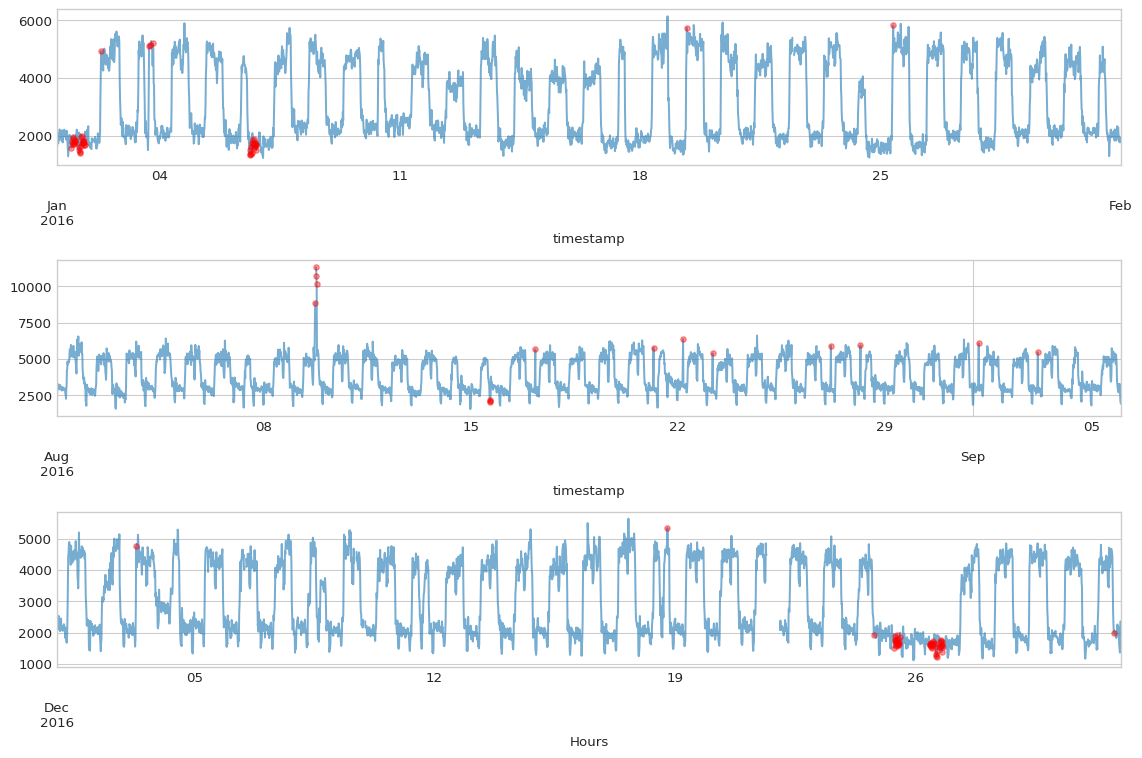

In [27]:
subset = consumption.loc[consumption.index.isin(outliers_global[outliers_global>0].index)]

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 8), dpi=96)
    layout = (3, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))
    ax3 = plt.subplot2grid(layout, (2, 0))
    
    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    consumption.loc[start:end].plot(ax=ax1, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax1, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass 
    
    start = datetime(2016, 8, 1, 0)
    end = datetime(2016, 9, 6, 0)
    consumption.loc[start:end].plot(ax=ax2, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax2, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    consumption.loc[start:end].plot(ax=ax3, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax3, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    ax3.set_xlabel('Hours')
    
fig.tight_layout()

#### Step 4: Local outlier detection

The final step of the outlier detection process retains from the outliers identified in the previous step only those that can be characterised as outliers when we also compare their values with the observations in the same day of the year. 

The rationale for this approach can be explained by looking at the next plot, which shows the actual and the predicted power consumption during the first two (2) weeks of 2016 in the dataset. An important observation from the plot is that the distance from the seasonal model’s predictions is not by itself enough for detecting outliers when the whole day is misrepresented by the model (here a holiday is treated as a normal day).

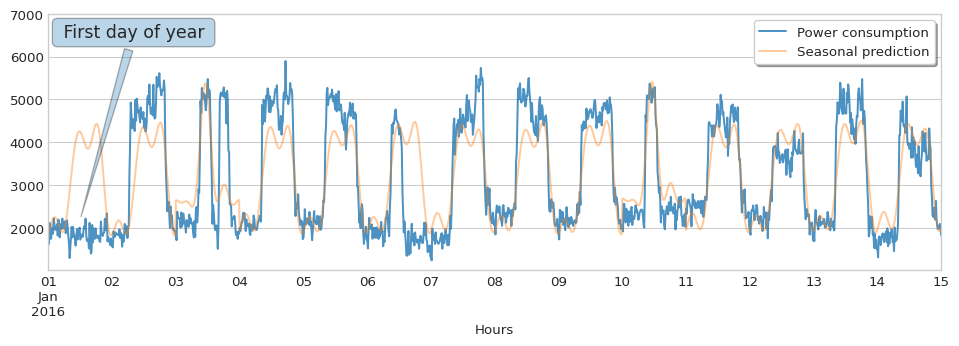

In [28]:
start = datetime(2016, 1, 1, 0)
end = datetime(2016, 1, 1, 0) + timedelta(days=14)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    consumption.loc[start:end].plot(ax=ax, alpha=0.8)
    pred.loc[start:end].plot(ax=ax, alpha=0.4)
    
    ax.set_ylim(top=7000)
    ax.annotate(' First day of year ', xy=(datetime(2016, 1, 1, 12), 2200),  xycoords='data',
             xytext=(40, 140), textcoords='offset points',
             size=13, ha='center', va="center",
             bbox=dict(boxstyle="round", alpha=0.3),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.3))
    
    ax.set_xlabel('Hours')
    ax.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)

Accordingly, the observations in the available dataset are marked as potential outliers if the value of their corresponding residuals lies outside the range defined by:

$$[median^{day} - c\times mad^{day}, median^{day} + c\times mad^{day}]$$

where:

$median^{day}$ is the median of all the residual values in the corresponding day

$mad^{day}$ is the median absolute deviation of all the residual values in the corresponding day

$c$ is a user defined parameter (suggested value is 8).


This step is parameterised by the minimum percentage of observations `min_samples` that must be available for any given day so that to take the daily statistics into account. If the number of the available observations is lower than this threshold, only the global outlier detection results are considered.

In [29]:
outliers_local = local_outlier_detect(resid, min_samples=0.66, c=8)

The result `outliers_local` is a pandas Series of outlier scores. Zero values mean no outlier, non zero values mean probable outlier, and the higher the score, the higher the probability:

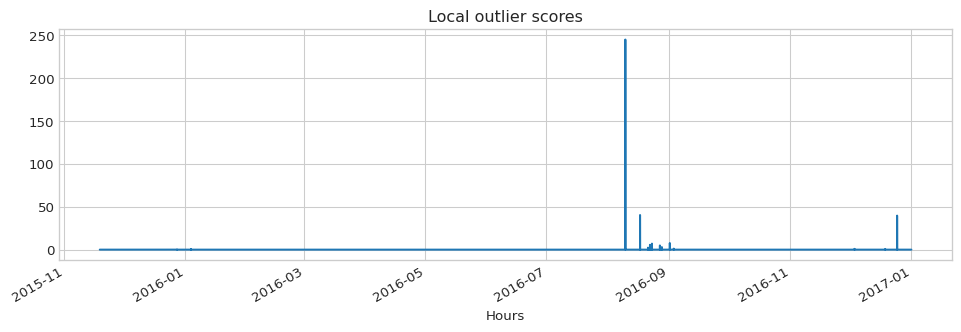

In [30]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    outliers_local.plot(ax=ax)
    ax.set_xlabel('Hours')
    ax.set_title('Local outlier scores')

The next plot shows the potential outliers in power consumption identified using the local outlier detection for January, August, first 5 days of September and December 2016:

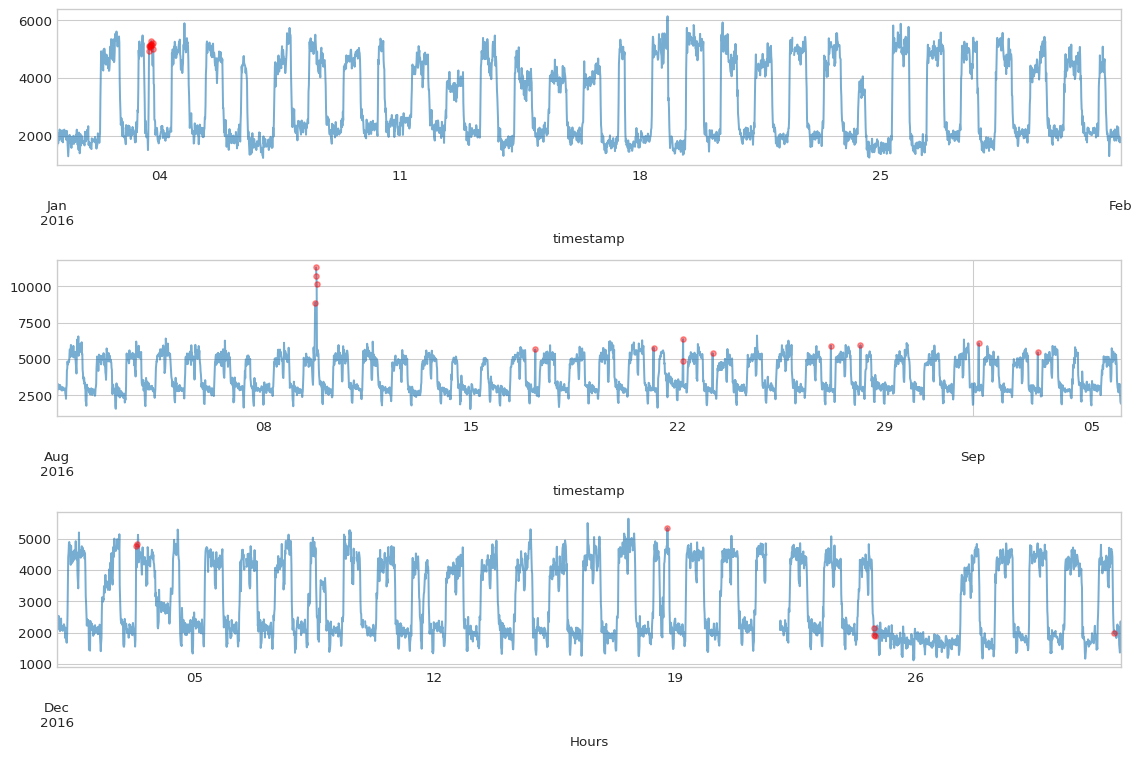

In [31]:
subset = consumption.loc[consumption.index.isin(outliers_local[outliers_local>0].index)]

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 8), dpi=96)
    layout = (3, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))
    ax3 = plt.subplot2grid(layout, (2, 0))
    
    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    consumption.loc[start:end].plot(ax=ax1, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax1, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    
    start = datetime(2016, 8, 1, 0)
    end = datetime(2016, 9, 6, 0)
    consumption.loc[start:end].plot(ax=ax2, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax2, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    consumption.loc[start:end].plot(ax=ax3, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax3, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    ax3.set_xlabel('Hours')
    
fig.tight_layout()

For an observation to be marked as an outlier, both global and local results must agree. 

In [32]:
no_outliers = np.logical_or(outliers_global==0, outliers_local==0)
outlier_sum = outliers_global + outliers_local
outlier_score = outlier_sum.mask(no_outliers, 0)

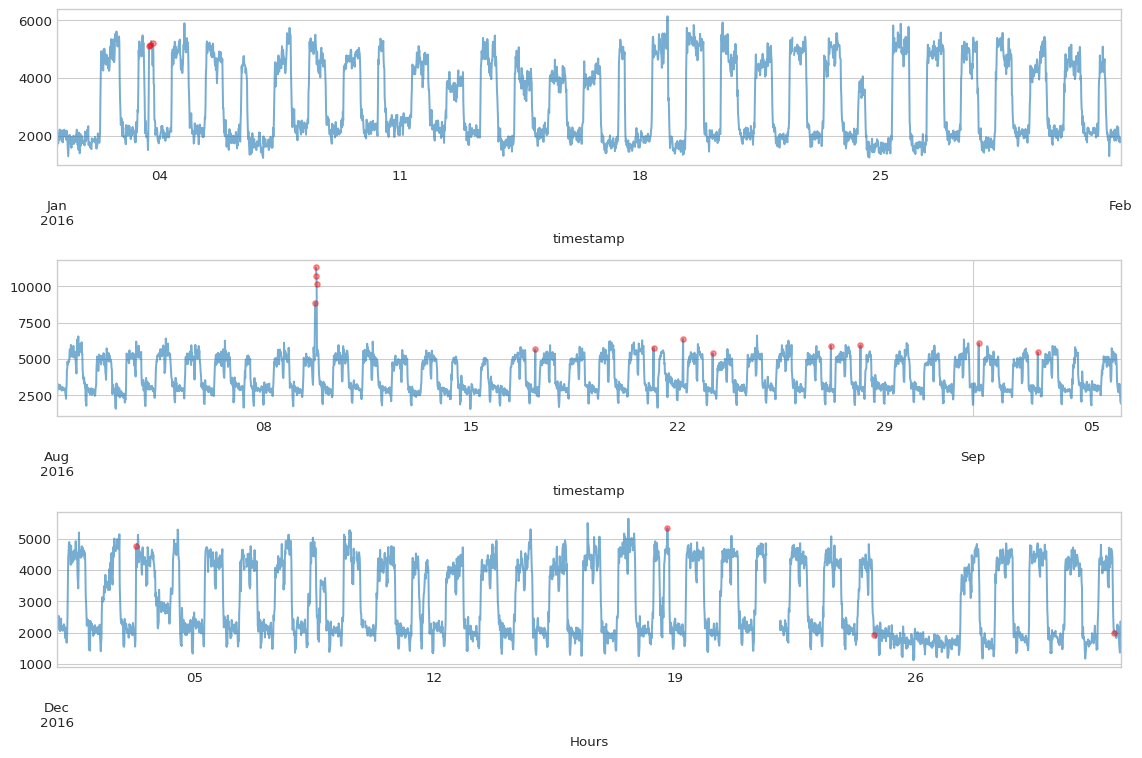

In [33]:
subset = consumption.loc[consumption.index.isin(outlier_score[outlier_score>0].index)]

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 8), dpi=96)
    layout = (3, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))
    ax3 = plt.subplot2grid(layout, (2, 0))
    
    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    consumption.loc[start:end].plot(ax=ax1, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax1, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    
    start = datetime(2016, 8, 1, 0)
    end = datetime(2016, 9, 6, 0)
    consumption.loc[start:end].plot(ax=ax2, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax2, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    consumption.loc[start:end].plot(ax=ax3, alpha=0.6)
    try:
        subset.loc[start:end].plot(ax=ax3, style='o', ms=4, c='red', alpha=0.4)
    except IndexError:
        pass
    ax3.set_xlabel('Hours')
    
fig.tight_layout()

The next plot shows the potential outliers identified in the whole consumption dataset:

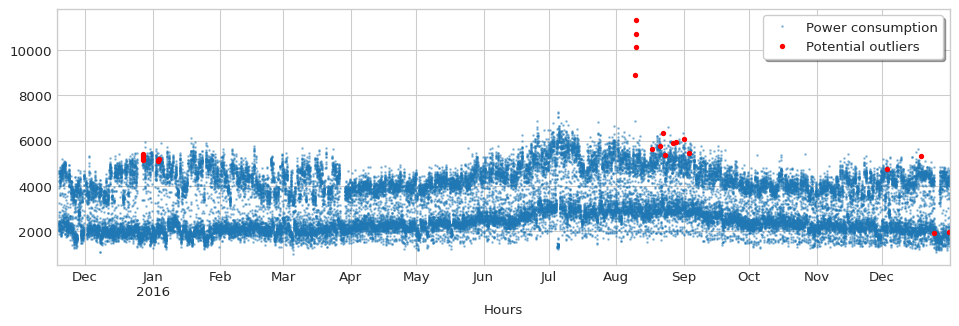

In [34]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption.plot(ax=ax, alpha=0.4, style='.', ms=2)
    
    try:
        subset = consumption.loc[consumption.index.isin(outlier_score[outlier_score>0].index)]
        subset.plot(ax=ax, style='o', ms=3, c='red')
    except IndexError:
        pass
    
    ax.set_xlabel('Hours')
    ax.legend(['Power consumption', 'Potential outliers'], frameon=True, shadow=True)

Another way to see which observations were identified as outliers is to plot the relevant daily profiles:

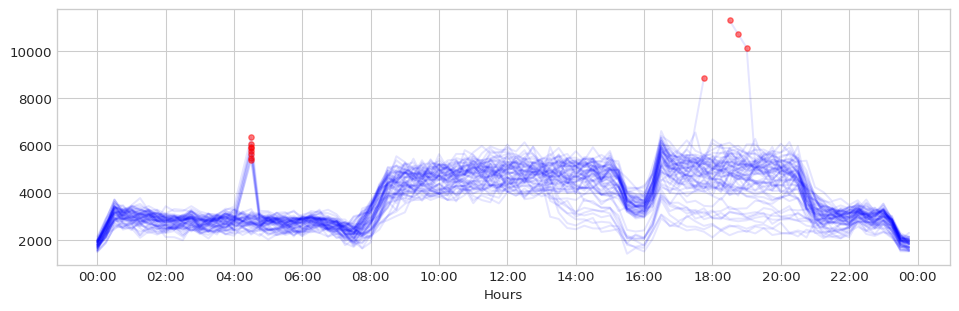

In [35]:
start = datetime(2016, 8, 1, 0)
end = datetime(2016, 10, 1, 0)

selected = consumption.loc[start:end].to_frame('consumption')
selected['day'] = selected.index.date
selected['time'] = selected.index.time
selected = selected.pivot(index='time', columns='day', values='consumption')

try:
    outlier_subset = consumption.loc[
                        consumption.index.isin(outlier_score[outlier_score>0].index)
                    ]
except IndexError:
    outlier_subset = None
else:
    outlier_subset = outlier_subset.loc[start:end]
    outlier_subset = outlier_subset.to_frame('outlier')
    outlier_subset['day'] = outlier_subset.index.date
    outlier_subset['time'] = outlier_subset.index.time
    outlier_subset = outlier_subset.pivot(index='time', columns='day', values='outlier')

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    selected.plot(ax=ax, alpha=0.1, legend=False, color='blue')
    
    if outlier_subset is not None:
        outlier_subset.plot(ax=ax, style='o', ms=4, alpha=0.5, 
                            legend=False, color='red')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')


The information about the outlier scores can be used as a way to limit the maximum number of outliers identified in a dataset. For instance, if we set the maximum mumber to be 0.5% of all observations, the outliers would be: 

In [36]:
threshold = 0.005
n_outliers = int(threshold * consumption.notna().sum())
outliers = outlier_score[outlier_score > 0].nlargest(n_outliers)

In [37]:
data_train['consumption'] = consumption
data_train['consumption_outlier'] = False
data_train.loc[outliers.index, 'consumption_outlier'] = True

### Repeat the process for temperature data

In [38]:
temperature = data_train['temperature']

In [39]:
temperature = global_filter(temperature, 
                            no_change_window=3,
                            max_pct_of_dummy=0.1,
                            allow_zero=True, 
                            allow_negative=True)

We apply seasonal decomposition on the temperature:

In [40]:
results = decompose_temperature(
        temperature.dropna().to_frame("temperature"),
        return_model=False
)

In [41]:
pred = results.prediction["temperature"]
resid = temperature - pred
resid = resid.dropna()

The distribution of the residuals resembles a Student’s t distribution:

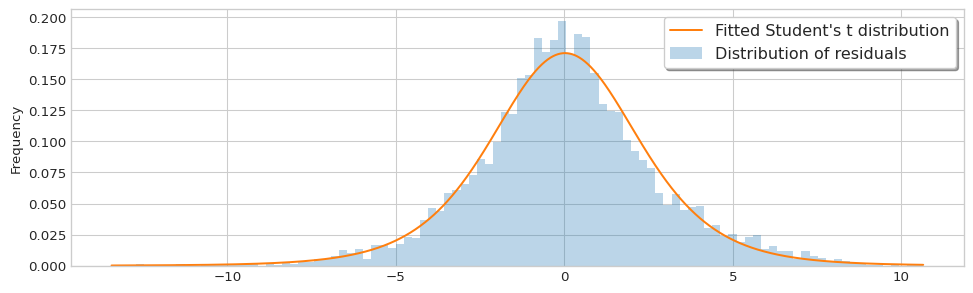

In [42]:
x_d = np.linspace(resid.min(), resid.max(), 2000)

_, pdf_t = fit_pdf(x_d, resid, distribution=stats.t)


with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    resid.plot(kind='hist', bins=100, density=True, alpha=0.3, ax=ax)
    pd.Series(pdf_t, x_d).plot(ax=ax)
    
    ax.legend(['Fitted Student\'s t distribution', 'Distribution of residuals'], 
              frameon=True, shadow=True, fontsize=12)

Outliers found in the dataset:

In [43]:
outliers_global = global_outlier_detect(resid, c=7)
outliers_local = local_outlier_detect(resid, min_samples=0.66, c=8)

no_outliers = np.logical_or(outliers_global==0, outliers_local==0)
outlier_sum = outliers_global + outliers_local
outlier_score = outlier_sum.mask(no_outliers, 0)

print(f'Number of outliers found: {outlier_score[outlier_score>0].sum()}')

Number of outliers found: 0.0


In [44]:
threshold = 0.005
n_outliers = int(threshold * temperature.notna().sum())
outliers = outlier_score[outlier_score>0].nlargest(n_outliers)

In [45]:
data_train['temperature'] = temperature
data_train['temperature_outlier'] = False
data_train.loc[outliers.index, 'temperature_outlier'] = True

All outliers - except for consumption - are replaced by `NaN`. 

In [46]:
columns = data_train.filter(like='outlier', axis=1).columns
to_drop = []

for col in columns:
    feature, _ = col.split('_')
    if feature != 'consumption':
        data_train[feature] = data_train[feature].mask(data_train[col], np.nan)
        to_drop.append(col)
        
data_train = data_train.drop(to_drop, axis=1)

### Impute missing values in the temperature data

In [47]:
print('Number of missing temperature values before: {}'
          .format(data_train['temperature'].isna().sum())
)

Number of missing temperature values before: 32201


In [48]:
data_train['temperature'] = linear_impute(data_train['temperature'], window=6)

In [49]:
print('Number of missing temperature values after: {}'
          .format(data_train['temperature'].isna().sum())
)

Number of missing temperature values after: 1938


### Ensure that enough training data is available

In [50]:
missing_condition = data_train['consumption_outlier'] | data_train.isna().any(axis=1)
missing = data_train[['consumption']].mask(missing_condition, np.nan)

In [51]:
missing_per_month = dict()

for month, group in missing.groupby([lambda x: x.month]):
        missing_per_month[month] = (
            np.sum(
                group.groupby([lambda x: x.day, lambda x: x.hour]).count() == 0
            ).item()
            / 720 # hours per month
        )

missing_per_month = {f'M{key}':val for key, val in missing_per_month.items()}
missing_per_month = pd.DataFrame.from_dict(
                            missing_per_month, 
                            orient='index', 
                            columns=['missing_pct']
                    )

In [52]:
print('Months with not enough data are:')
print(missing_per_month[missing_per_month['missing_pct'] > 0.1])

Months with not enough data are:
Empty DataFrame
Columns: [missing_pct]
Index: []


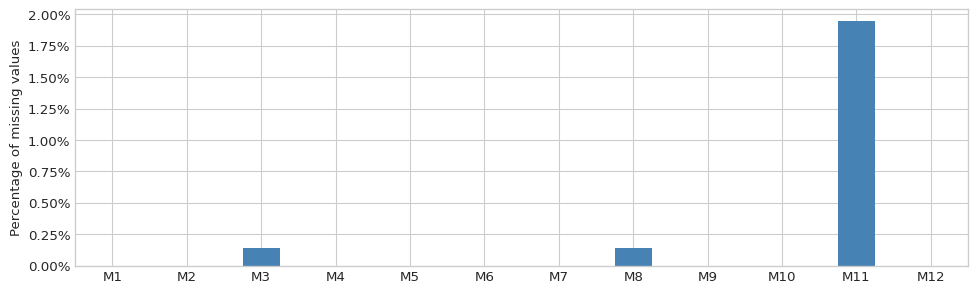

In [53]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    subset = 100 * missing_per_month.mask(missing_per_month['missing_pct'] <= 0.1, 0) 
    subset.plot.bar(rot=25, ax=ax, color='#C71585', legend=False)
    
    subset = 100  *missing_per_month.mask(missing_per_month['missing_pct'] > 0.1, 0)
    subset.plot.bar(rot=0, ax=ax, color='#4682B4', legend=False)
    
    ax.set_ylabel('Percentage of missing values')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

### Save to the catalog

In [54]:
catalog.save('train.preprocessed_data', data_train)
catalog.save('train.model_input_data', data_train.dropna())

2021-11-14 17:09:41,214 - kedro.io.data_catalog - INFO - Saving data to `train.preprocessed_data` (CSVDataSet)...
2021-11-14 17:09:41,514 - kedro.io.data_catalog - INFO - Saving data to `train.model_input_data` (CSVDataSet)...


--------------------------